In [ ]:
# marimo notebook
import marimo as mo

# Core Earthmover stack
import arraylake as al
import icechunk as ic
import xarray as xr

# Climate indices
import metpy
import xclim

# Physical units support
import pint
import pint_xarray
from metpy.units import units

# Maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Speeds up groupby / coarsen
import flox

# Climate risk indicators from ERA5

We will access the copy of ERA5 surface data on Arraylake, then calculate some climate risk indicators. To do this we will run basic Xarray queries that are accelerated by Icechunk, experiencing the speed of the Earthmover platform firsthand.

## Connect to Arraylake

Now let's login to arraylake. We can [login to the web app](https://app.earthmover.io/earthmover-public/era5-surface-aws), or log in from the notebook programatically via the client.

In [ ]:
client = al.Client()
client.login()


🔓 Successfully refreshed tokens!
> Token stored at /Users/tom-em/.arraylake/token.json

╭───────────────────────────────────────────────────────────────────────────────── 👤 User Details ─────────────────────────────────────────────────────────────────────────────────╮
│ Name: Tom Nicholas                                                                                                                                                                │
│ Email: tom@earthmover.io                                                                                                                                                          │
│ Id: 0a632e93-b8ec-4114-b352-d4ba6615c826                                                                                                                                          │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


🔓 Successfully logged in!
> Token stored at /Users/tom-em/.arraylake/token.json

╭───────────────────────────────────────────────────────────────────────────────── 👤 User Details ─────────────────────────────────────────────────────────────────────────────────╮
│ Name: Tom Nicholas                                                                                                                                                                │
│ Email: tom@earthmover.io                                                                                                                                                          │
│ Id: 0a632e93-b8ec-4114-b352-d4ba6615c826                                                                                                                                          │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


## ERA5 in Icechunk

The `earthmover-public` org in arraylake contains some example public datasets. Let's take a look at the ECMWF Reanalysis v5 dataset, more commonly known as ERA5. We can [view the ERA5 repo in the arraylake web app](https://app.earthmover.io/earthmover-public/era5-surface-aws).

We can alternatively use the client to see information about the repo, such as which bucket the data resides in.

In [ ]:
client.get_repo_object("earthmover-public/era5-surface-aws")

<arraylake.Repo>
 Repository: earthmover-public/era5-surface-aws
 Description: Surface variables from the ECMWF ERA5 reanalysis for 1975-2025. See documentation at https://docs.earthmover.io/sample-data/era5 to get started.
 Metadata:
 source: ECMWF
 purpose: analytics
 Kind: icechunk
 Visibility: AUTHENTICATED_PUBLIC
 Prefix: era5_surface_aws
 Status: online
 Status message: new repo creation
 Bucket: earthmover (s3)
 Bucket name: ems-earthmover-public-0f0978f1
 Optimization:
 GC: enabled
 Created: 2025-07-07 15:03:56 UTC
 Updated: 2025-08-08 12:14:50 UTC
 Created by: fe4194e9-1a4b-453b-b656-7adb333ca692

Whilst the web app shows us various metadata about the contents of the repo, to actually access data we need to use the client to open the underlying Icechunk repository:

In [ ]:
ic_repo = client.get_repo("earthmover-public/era5-surface-aws")

Icechunk is Earthmover's open-source transactional storage engine. You can think of it as "version-controlled, multiplayer Zarr".

Icechunk is incredibly powerful, and you can read more about it in the [icechunk documentation](https://icechunk.io/en/latest/), and on the [Earthmover Blog](https://earthmover.io/blog).

For today, in this notebook, Icechunk will mainly be behind-the-scences.

To access the data in Icechunk via zarr, we need to start an icechunk `Session`, then get the Zarr store object.

In [ ]:
session = ic_repo.readonly_session("main")
icechunk_store = session.store

Now we have something that xarray can read from!

In [ ]:
ds = xr.open_dataset(icechunk_store, group="spatial", engine="zarr", zarr_format=3, chunks={})
ds

<xarray.Dataset> Size: 40TB
Dimensions: (time: 438312, latitude: 721, longitude: 1440)
Coordinates:
 * latitude (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
 * longitude (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
 * time (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/22)
 d2 (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 cp (latitude, longitude, time) float32 2TB dask.array<chunksize=(721, 1440, 72), meta=np.ndarray>
 blh (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 cape (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 mslp (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 sp (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 ... ...
 u10 (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 tcw (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 tcwv (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 v10 (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 t2 (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
 v100 (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
 DATA_SOURCE: ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
 Conventions: CF-1.6
 history: Created by Earthmover PBC on 2025-09-06 21:03:36 by combini... xarray.Dataset Dimensions: time : 438312 latitude : 721 longitude : 1440 Coordinates: (3) latitude (latitude) float64 90.0 89.75 89.5 ... -89.75 -90.0 long_name : latitude short_name : lat units : degrees_north axis : Y array([ 90. , 89.75, 89.5 , ..., -89.5 , -89.75, -90. ], shape=(721,)) longitude (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8 long_name : longitude short_name : lon units : degrees_east axis : X array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
 3.5975e+02], shape=(1440,)) time (time) datetime64[ns] 1975-01-01 ... 2024-12-31T23:00:00 long_name : time axis : T array(['1975-01-01T00:00:00.000000000', '1975-01-01T01:00:00.000000000',
 '1975-01-01T02:00:00.000000000', ..., '2024-12-31T21:00:00.000000000',
 '2024-12-31T22:00:00.000000000', '2024-12-31T23:00:00.000000000'],
 shape=(438312,), dtype='datetime64[ns]') Data variables: (22) d2 (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray> long_name : 2 metre dewpoint temperature short_name : 2d units : K original_format : WMO GRIB 1 with ECMWF local table ecmwf_local_table : 128 ecmwf_parameter : 168 minimum_value : 206.40997314453125 maximum_value : 302.83978271484375 grid_specification : 0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude) rda_dataset : ds633.0 rda_dataset_url : https:/rda.ucar.edu/datasets/ds633.0/ rda_dataset_doi : DOI: 10.5065/BH6N-5N20 rda_dataset_group : ERA5 atmospheric surface analysis [netCDF4] QuantizeGranularBitGroomNumberOfSignificantDigits : 7 dask.array cp (latitude, longitude, time) float32 dask.array<chunksize=(721, 1440, 72), meta=np.ndarray> long_name : Convective precipitation short_name : cp units : m original_format : WMO GRIB 1 with ECMWF local table ecmwf_local_table : 128 ecmwf_parameter : 143 minimum_value : 0.0 maximum_value : 0.018028736114501953 grid_specification : 0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude) rda_dataset : ds633.0 rda_dataset_url : https:/rda.ucar.edu/datasets/ds633.0/ rda_dataset_doi : DOI: 10.5065/BH6N-5N20 rda_dataset_group : ERA5 atmospheric surface forecast (accumulated) [netCDF4] QuantizeGranularBitGroomNumberOfSignificantDigits : 7 dask.array blh (tim

This `xarray.Dataset` represents a lazy view of the data in the `"spatial"` group of the zarr data in the `era5-surface-aws` repo.

In [ ]:
print(f"This repo contains {ds.nbytes / 1e12:.2g} TB of data!")

This repo contains 40 TB of data!


Note that we obviously did not just download 40TB of data in one second - instead we only downloaded the zarr metadata to learn what data we have in the store. This works because Zarr is a [cloud-optimized data format](https://earthmover.io/blog/fundamentals-what-is-cloud-optimized-scientific-data).

## Precipitation

This dataset has lots of interesting variables, but let's try plotting just one first - precipitation. We can look at the metadata of the `"cp"` variable to confirm that that's the one that represents precipitation.

In [ ]:
ds["cp"].attrs

Now as this dataset is global, we should pick a map projection, for which we'll use the cartopy library. Let's also pick a date and time to display the data.

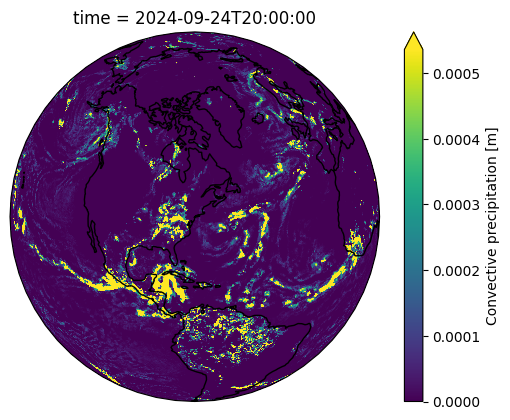

In [ ]:
p1 = (
    ds["cp"]
    .sel(time="2024-09-24T20:00:00", method="nearest")  # subset to the same date and time last year
    .plot(
        subplot_kws={
            "projection": ccrs.Orthographic(-73.99, 40.73),  # center over NYC
            "facecolor": "gray"
        },
        transform=ccrs.PlateCarree(),
        robust=True,
    )
)
p1.axes.set_global()
p1.axes.coastlines()

Voila! What the convective precipitation looked like globally (centered over New York) on this date and time last year.

Notice that region of high precipitation on the western tip of Cuba - that's [Hurricane Helene](https://en.wikipedia.org/wiki/Hurricane_Helene) developing, which went on to hit the South-Eastern US, causing almost $80 billion in damage.

## Spatial Analysis: Wet bulb temperature during 2024 Indian heatwave

Now let's calculate some quantities related to climate risk.

We'll start with the [wet bulb temperature](https://en.wikipedia.org/wiki/Wet-bulb_temperature), which is a measure of heat stress, particularly for human health and safety. Prolonged periods above a wet bulb temperature of 95°F are likely to be fatal to even fit and healthy humans.

Let's look at how high the wet bulb temperature got during the [2024 Indian heatwave](https://en.wikipedia.org/wiki/2024_Indian_heat_wave). We'll start by subsetting to a bounding box over India and Bangladesh, and a specific time within the (months-long) heatwave.

In [ ]:
india_bbox = {
    "longitude": slice(67, 99),
    "latitude": slice(37.5, 5),
}

ds_india = ds[
    ["sp", "t2", "d2"]  # keep only the variables we need to calculate wet bulb temperature
].sel(
    **india_bbox, 
    time="2024-05-28T10:00:00",  # subset to a time within the 2024 Indian heatwave
).load().pint.quantify()  # use pint-xarray to automatically handle unit conversions

ds_india

Magnitude,[37.5 37.25 37.0 36.75 36.5 36.25 36.0 35.75 35.5 35.25 35.0 34.75 34.5 34.25 34.0 33.75 33.5 33.25 33.0 32.75 32.5 32.25 32.0 31.75 31.5 31.25 31.0 30.75 30.5 30.25 30.0 29.75 29.5 29.25 29.0 28.75 28.5 28.25 28.0 27.75 27.5 27.25 27.0 26.75 26.5 26.25 26.0 25.75 25.5 25.25 25.0 24.75 24.5 24.25 24.0 23.75 23.5 23.25 23.0 22.75 22.5 22.25 22.0 21.75 21.5 21.25 21.0 20.75 20.5 20.25 20.0 19.75 19.5 19.25 19.0 18.75 18.5 18.25 18.0 17.75 17.5 17.25 17.0 16.75 16.5 16.25 16.0 15.75 15.5 15.25 15.0 14.75 14.5 14.25 14.0 13.75 13.5 13.25 13.0 12.75 12.5 12.25 12.0 11.75 11.5 11.25 11.0 10.75 10.5 10.25 10.0 9.75 9.5 9.25 9.0 8.75 8.5 8.25 8.0 7.75 7.5 7.25 7.0 6.75 6.5 6.25 6.0 5.75 5.5 5.25 5.0]
Units,degrees_north
Magnitude,[67.0 67.25 67.5 67.75 68.0 68.25 68.5 68.75 69.0 69.25 69.5 69.75 70.0 70.25 70.5 70.75 71.0 71.25 71.5 71.75 72.0 72.25 72.5 72.75 73.0 73.25 73.5 73.75 74.0 74.25 74.5 74.75 75.0 75.25 75.5 75.75 76.0 76.25 76.5 76.75 77.0 77.25 77.5 77.75 78.0 78.25 78.5 78.75 79.0 79.25 79.5 79.75 80.0 80.25 80.5 80.75 81.0 81.25 81.5 81.75 82.0 82.25 82.5 82.75 83.0 83.25 83.5 83.75 84.0 84.25 84.5 84.75 85.0 85.25 85.5 85.75 86.0 86.25 86.5 86.75 87.0 87.25 87.5 87.75 88.0 88.25 88.5 88.75 89.0 89.25 89.5 89.75 90.0 90.25 90.5 90.75 91.0 91.25 91.5 91.75 92.0 92.25 92.5 92.75 93.0 93.25 93.5 93.75 94.0 94.25 94.5 94.75 95.0 95.25 95.5 95.75 96.0 96.25 96.5 96.75 97.0 97.25 97.5 97.75 98.0 98.25 98.5 98.75 99.0]
Units,degrees_east
Magnitude,[[97119.46875 97067.46875 96261.46875 ... 62406.46875 63113.46875 63703.46875] [97728.46875 97307.46875 97064.46875 ... 63627.46875 63327.46875 64333.46875] [97820.46875 97758.46875 97475.46875 ... 66583.46875 65207.46875 65042.46875] ... [100791.46875 100788.46875 100776.46875 ... 100582.46875 100640.46875 100505.46875] [100785.46875 100789.46875 100798.46875 ... 100461.46875 100573.46875 100556.46875] [100787.46875 100785.46875 100796.46875 ... 100600.46875 100550.46875 100577.46875]]
Units,pascal
Magnitude,[[308.7694091796875 308.6971435546875 307.8865966796875 ... 279.2791748046875 280.5916748046875 281.6678466796875] [308.2830810546875 307.9119873046875 307.8572998046875 ... 279.6170654296875 279.5115966796875 280.9237060546875] [307.5662841796875 307.5858154296875 307.6131591796875 ... 281.7147216796875 280.4803466796875 280.7381591796875] ... [301.5643310546875 301.5467529296875 301.6287841796875 ... 302.8514404296875 302.6971435546875 302.7049560546875] [301.4530029296875 301.2596435546875 301.2987060546875 ... 302.9061279296875 302.7147216796875 302.5740966796875] [301.4705810546875 301.3631591796875 301.2322998046875 ... 302.9725341796875 302.7615966796875 302.4920654296875]]
Units,kelvin
Magnitude,[[274.16790771484375 274.00579833984375 273.52728271484375 ... 273.08978271484375 273.64642333984375 274.13861083984375] [274.70111083984375 274.73822021484375 274.43157958984375 ... 273.63079833984375 274.34564208984375 275.08197021484375] [275.40618896484375 275.50579833984375 275.68548583984375 ... 274.32220458984375 274.44329833984375 274.95697021484375] ... [298.74212646484375 298.78314208984375 298.68157958984375 ... 299.70697021484375 299.70111083984375 299.49017333984375] [298.66009521484375 298.75970458984375 298.71868896484375 ... 299.42376708984375 299.37298583984375 299.18743896484375] [298.45501708984375 298.50384521484375 298.62103271484375 ... 299.29095458984375 299.08197021484375 298.83587646484375]]
Units,kelvin


Calculating wet-bulb temperature isn't trivial (it requires an iterative algorithm), but luckily the [MetPy package](https://unidata.github.io/MetPy/latest/index.html) conveniently provides an xarray-aware [function](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wet_bulb_temperature.html#wet-bulb-temperature) for calculating wet bulb temperature for us.

In [ ]:
from metpy.calc import wet_bulb_temperature

In [ ]:
wbt = wet_bulb_temperature(
    pressure=ds_india["sp"],
    temperature=ds_india["t2"],
    dewpoint=ds_india["d2"],
).pint.to(pint.Unit("degF"))
wbt

Magnitude,[[60.47844259548265 60.34958977408037 59.54366803750449 ... 36.895956916541394 38.39814729410281 39.645106961858154] [60.54336932662842 60.297827164793084 60.07870410182608 ... 37.67413300797505 38.219425818229816 39.97081960973625] [60.511217900852536 60.569124725867155 60.65001440091343 ... 39.97711703681843 39.10332043780908 39.748320941166234] ... [79.25028728342957 79.29790985012714 79.19581192978221 ... 81.0643015112146 80.99616946901476 80.71295076792929] [79.0945946885925 79.14804362953582 79.10928026716427 ... 80.7028204802387 80.55982418070539 80.25447106764807] [78.8285266002382 78.84881291733909 78.95098149196633 ... 80.55268509248417 80.18853764999828 79.75228343777876]]
Units,degree_Fahrenheit


Note: To understand how on earth all the physical units conversions were just magically handled correctly for us there, [read this blog post about `pint-xarray`](https://xarray.dev/blog/introducing-pint-xarray) that I wrote back in 2022.

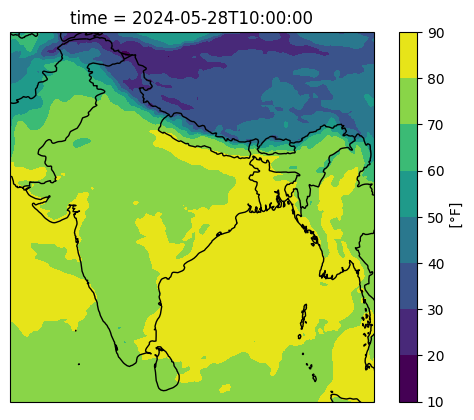

In [ ]:
p = wbt.plot.contourf(
    subplot_kws={"projection": ccrs.PlateCarree(), "facecolor": "lightgray"},
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines(resolution='50m')
p.axes.add_feature(cfeature.BORDERS)

If 95F is lethal, then clearly the temperature and humidity was dangerously high over significant areas, particularly in east India and Bangladesh.

Indeed there were a total of 219 deaths reported from the heat wave, and 25,000 others suffered from heatstroke ([source: wikipedia](https://en.wikipedia.org/wiki/2024_Indian_heat_wave)).

## Temporal Analysis: Heat wave index

So far we have analysed large spatial regions at specific times. We also do the opposite - analyse trends at specific locations over long time periods. Let's calculate the number of days each year that New York City experienced a heatwave.

For analyses to work efficiently, our queries need to be aligned with our chunking pattern on-disk. We now want to use the orthogonal query pattern, so let's open a slightly different version of the ERA5 dataset, this time with spatial instead of temporal chunking.

In [ ]:
ds_temporal = xr.open_dataset(session.store, group="temporal", engine="zarr", zarr_format=3, chunks={})
ds_temporal

<xarray.Dataset> Size: 40TB
Dimensions: (time: 438312, latitude: 721, longitude: 1440)
Coordinates:
 * latitude (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
 * longitude (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
 * time (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/22)
 mslp (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 cape (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 cp (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 lsp (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 d2 (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 sd (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 ... ...
 stl1 (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 tcw (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 tcc (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 v100 (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 tcwv (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
 v10 (time, latitude, longitude) float32 2TB dask.array<chunksize=(8736, 12, 12), meta=np.ndarray>
Attributes:
 DATA_SOURCE: ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
 Conventions: CF-1.6
 history: Created by Earthmover PBC on 2025-09-06 21:03:36 by combini... xarray.Dataset Dimensions: time : 438312 latitude : 721 longitude : 1440 Coordinates: (3) latitude (latitude) float64 90.0 89.75 89.5 ... -89.75 -90.0 long_name : latitude short_name : lat units : degrees_north axis : Y array([ 90. , 89.75, 89.5 , ..., -89.5 , -89.75, -90. ], shape=(721,)) longitude (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8 long_name : longitude short_name : lon units : degrees_east axis : X array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
 3.5975e+02], shape=(1440,)) time (time) datetime64[ns] 1975-01-01 ... 2024-12-31T23:00:00 long_name : time axis : T array(['1975-01-01T00:00:00.000000000', '1975-01-01T01:00:00.000000000',
 '1975-01-01T02:00:00.000000000', ..., '2024-12-31T21:00:00.000000000',
 '2024-12-31T22:00:00.000000000', '2024-12-31T23:00:00.000000000'],
 shape=(438312,), dtype='datetime64[ns]') Data variables: (22) mslp (time, latitude, longitude) float32 dask.array<chunksize=(8736, 12, 12), meta=np.ndarray> long_name : Mean sea level pressure short_name : msl units : Pa original_format : WMO GRIB 1 with ECMWF local table ecmwf_local_table : 128 ecmwf_parameter : 151 minimum_value : 93482.4375 maximum_value : 105961.5625 grid_specification : 0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude) rda_dataset : ds633.0 rda_dataset_url : https:/rda.ucar.edu/datasets/ds633.0/ rda_dataset_doi : DOI: 10.5065/BH6N-5N20 rda_dataset_group : ERA5 atmospheric surface analysis [netCDF4] QuantizeGranularBitGroomNumberOfSignificantDigits : 7 dask.array cape (time, latitude, longitude) float32 dask.array<chunksize=(8736, 12, 12), meta=np.ndarray> long_name : Convective available potential energy short_name : cape units : J kg**-1 original_format : WMO GRIB 1 with ECMWF local table ecmwf_local_table : 128 ecmwf_parameter : 59 minimum_value : 0.0 maximum_value : 21667.5 grid_specification : 0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude) rda_dataset : ds633.0 rda_dataset_url : https:/rda.ucar.edu/datasets/ds633.0/ rda_dataset_doi : DOI: 10.5065/BH6N-5N20 rda_dataset_group : ERA5 atmospheric surface analysis [netCDF4] QuantizeGranularBitGroomNumberOfSignificantDigits : 7 dask.array cp (time, latitude, longitud

The official [NYC Hazard Mitigation Plan](https://nychazardmitigation.com/documentation/hazard-profiles/extreme-heat/) defines heatwaves in terms of the National Weather Service's heat index chart. This quantity is a function of air temperature and relative humidity.

<figure>
  <img src="https://nychazardmitigation.com/wp-content/uploads/2023/01/2024.08.05_12_Heat-Index.png)" alt="Alt text" width="600">
  <figcaption>Heat index table. Source: National Weather Service.</figcaption>
</figure>

Again we will need both the temperature and the dewpoint temperature.

In [ ]:
nyc_coords = {"latitude": 41, "longitude": 286}

ds_nyc = ds_temporal[['t2', 'd2']].sel(**nyc_coords, method="nearest").load().pint.quantify()
ds_nyc

Magnitude,[273.837158203125 273.63134765625 273.29736328125 ... 282.2607421875 280.92657470703125 280.7290344238281]
Units,kelvin
Magnitude,[269.54833984375 269.6611633300781 270.8155517578125 ... 275.57574462890625 276.15374755859375 276.32940673828125]
Units,kelvin


To calculate this we can use metpy again, but first we need to find the relative humidity.

In [ ]:
from metpy.calc import relative_humidity_from_dewpoint
from metpy.calc import heat_index

In [ ]:
rel_humid = relative_humidity_from_dewpoint(
    temperature=ds_nyc['t2'],
    dewpoint=ds_nyc['d2'],
)

In [ ]:
heat_ind = heat_index(
    temperature=ds_nyc['t2'],
    relative_humidity=rel_humid,
    mask_undefined=False,
).pint.to(units.degF)

Only the maximum heat index reached on a given day matters for whether or not that day is considered part of a heatwave, so let's calculate the daily maximum heat index over all time.

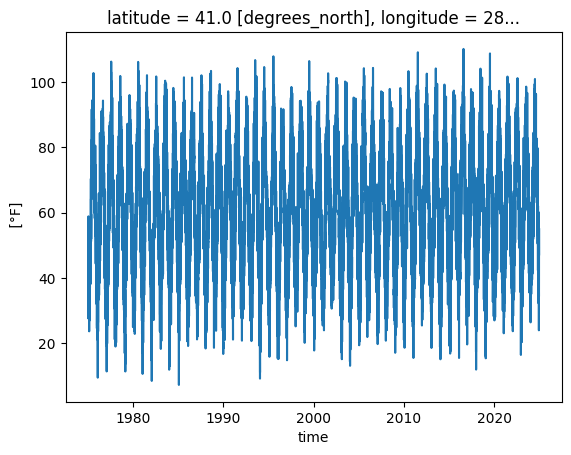

In [ ]:
heat_ind_daily_max = heat_ind.coarsen(time=24).max()
heat_ind_daily_max.plot()

That looks sensible - it has the right magnitude, the right units, and shows an annual cycle.

NYC Emergency Management issues a "heat advisory" if the heat index is greater than 95°F for two consecutive days.

There is another xarray-based open-source package called [`xclim`](https://xclim.readthedocs.io/en/stable/index.html) which has a [convenient function](https://xclim.readthedocs.io/en/stable/indices.html#xclim.indices.heat_wave_index) for calculating the number of days in a year that match this criterion.

In [ ]:
from xclim.indices import heat_wave_index

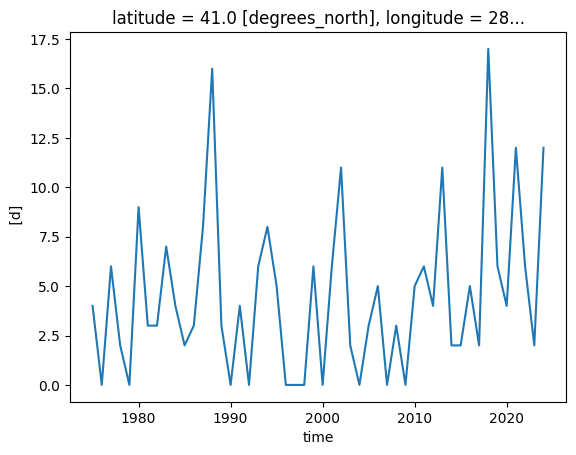

In [ ]:
heat_wave_index(
    heat_ind_daily_max.pint.dequantify(), 
    thresh='95.0 degF', 
    window=2,
).plot()

Looks like the average number of heatwave days per year in NYC is ~10, and has been increasing noticeably over the last decade or so.

From [nychazardmitigation.com](https://nychazardmitigation.com/documentation/hazard-profiles/extreme-heat/#probability:~:text=The%202024%20New%20York%20City%20Panel%20on%20Climate%20Change%20(NPCC)%20report%20(NPCC4)%20estimated%20that%20from%201981%20to%202010%2C%20New%20York%20City%20had%20an%20average%20of%2017%20days%20per%20year%20with%20maximum%20temperatures%20at%20or%20above%2090%C2%B0F%20and%20had%20heat%20waves%20lasting%20an%20average%20of%20four%20days):

> The 2024 New York City Panel on Climate Change (NPCC) report (NPCC4) estimated that from 1981 to 2010, New York City had an average of 17 days per year with maximum temperatures at or above 90°F and had heat waves lasting an average of four days.

So our quick estimate seems consistent with the official analysis.

## Conclusion

We have:

- Viewed and accessed a subset of 40TB of ERA5 data in arraylake,
- Plotted quantities of interest globally and regionally at specific times,
- Computed quantities of interest locally over the whole time history.

All of this using open-source packages, accessing Earthmover's public ERA5 Icechunk dataset in the cloud, from your laptop!